In [1]:
!pip install transformers
!pip install accelerate
!pip install datasets
!pip install bertviz
!pip install umap-learn


In [2]:
import pandas as pd

df = pd.read_excel('fake_news.xlsx')
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [3]:
# Check null values
df.isnull().sum()

,0
id,0
title,558
author,1957
text,43
label,0


In [4]:
len(df)

20800

In [5]:
# Drop null rows
df.dropna(inplace=True)

In [6]:
# use only 20% of the data for performance
from sklearn.model_selection import train_test_split

df, _ = train_test_split(df, test_size=0.8, random_state=42)

In [7]:
len(df)

3656

In [8]:
# Label Distribution
df['label'].value_counts()

,count
label,
0,2022
1,1634


0: relliable
1: unreliable

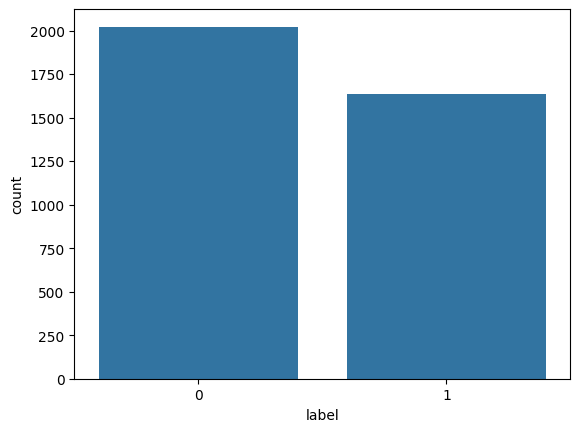

In [9]:
# plot label distribution
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='label', data=df)
plt.show()

In [10]:
# Import necessary libraries
# import spacy
# nlp = spacy.load('en_core_web_sm')  # Load spaCy's English model for natural language processing

# Define a function to count tokens using spaCy
# This function processes the input text using spaCy and returns the total number of tokens
def count_tokens(text):
    doc = nlp(text)  # Process the text using spaCy's NLP pipeline
    return len(doc)  # Return the number of tokens in the processed text

# For performance reasons, we approximate the number of tokens instead of using spaCy directly.
# The approximation assumes that the number of tokens is 1.5 times the number of words.
# This is a practical workaround when computational resources are limited.

# Calculate the number of words in the 'title' column
df['num_words'] = df['title'].apply(lambda x: len(x.split()))  # Count words by splitting text on spaces

# Calculate the approximate number of tokens in the 'title' column
df['num_tokens'] = df['title'].apply(lambda x: int(len(x.split()) * 1.5))  # Approximate tokens as 1.5 times the number of words

# Uncomment the line below to use spaCy for token count calculation instead of approximation
# df['num_tokens'] = df['title'].apply(lambda x: count_tokens(x))

# Calculate the number of words in the 'text' column
df['num_words_text'] = df['text'].apply(lambda x: len(x.split()))  # Count words in the 'text' column by splitting on spaces

# Calculate the approximate number of tokens in the 'text' column
df['num_tokens_text'] = df['text'].apply(lambda x: int(len(x.split()) * 1.5))  # Approximate tokens as 1.5 times the number of words

# Uncomment the line below to use spaCy for token count calculation instead of approximation
# df['num_tokens_text'] = df['text'].apply(lambda x: count_tokens(x))


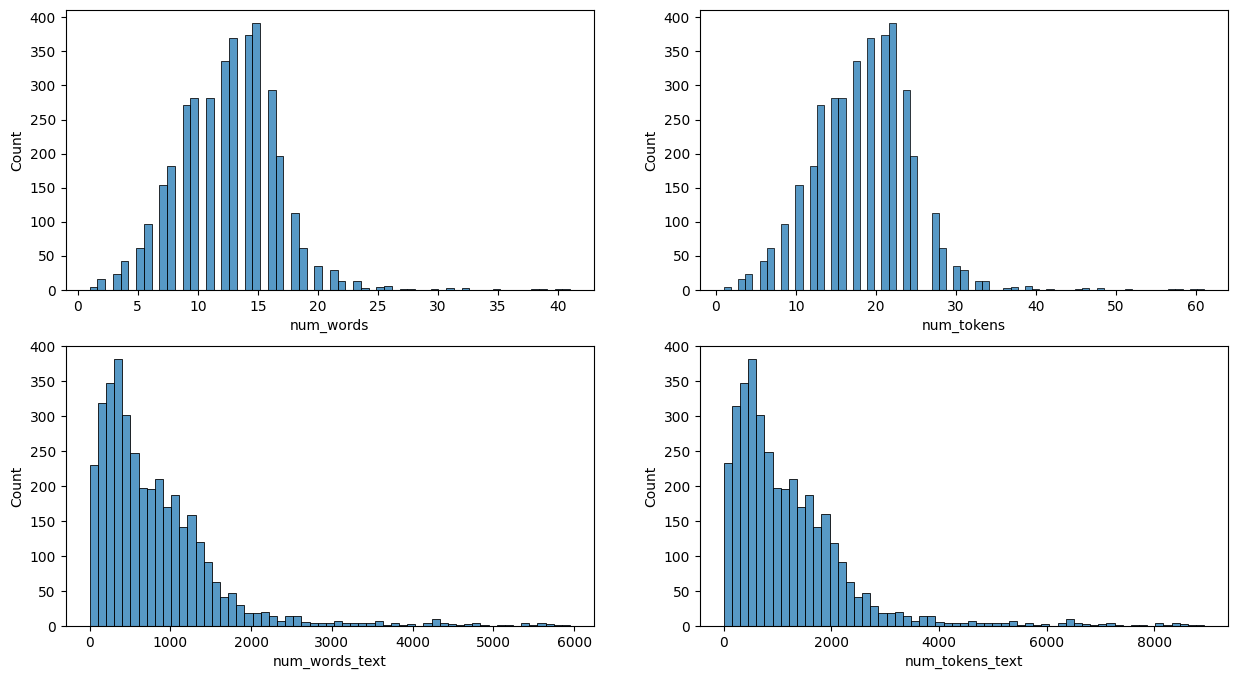

In [11]:
# Visualization
fig,ax = plt.subplots(2,2,figsize=(15,8))
sns.histplot(data=df,x='num_words',ax=ax[0,0])
sns.histplot(data=df,x='num_tokens',ax=ax[0,1])
sns.histplot(data=df,x='num_words_text',ax=ax[1,0])
sns.histplot(data=df,x='num_tokens_text',ax=ax[1,1])
plt.show()

# Splitting the data

In [12]:

# Step 1: Split the data into training and testing sets
# 'test_size=0.3' means 30% of the data will go to the testing set, and 70% to the training set.
# 'random_state=42' ensures reproducibility of the split.
# 'stratify=df['label']' ensures that the class distribution in the 'label' column is preserved in both splits.
train, test = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])

# Step 2: Further split the testing set into testing and validation sets
# 'test_size=1/3' means 1/3 of the original testing set (10% of the total dataset) will be used for validation.
# The remaining 2/3 of the original testing set (20% of the total dataset) will remain as the testing set.
# 'stratify=test['label']' ensures the class distribution is preserved in both splits.
test, validate = train_test_split(test, test_size=1/3, random_state=42, stratify=test['label'])

# Step 3: Display the shapes of the resulting datasets
# 'train.shape', 'test.shape', and 'validate.shape' show the number of rows and columns in each set.
train.shape, test.shape, validate.shape


((2559, 9), (731, 9), (366, 9))

In [13]:
from datasets import Dataset, DatasetDict

# Convert the training DataFrame into a Hugging Face Dataset
# 'Dataset.from_pandas()' creates a Dataset object from the Pandas DataFrame 'train'.
train_dataset = Dataset.from_pandas(train)

# Convert the testing DataFrame into a Hugging Face Dataset
# This ensures compatibility with Hugging Face tools and libraries.
test_dataset = Dataset.from_pandas(test)

# Convert the validation DataFrame into a Hugging Face Dataset
validate_dataset = Dataset.from_pandas(validate)

# Combine the individual datasets (train, test, validate) into a DatasetDict
# 'DatasetDict' is a dictionary-like structure where each key corresponds to a split (e.g., 'train', 'test', 'validate').
dataset = DatasetDict({
    'train': train_dataset,      # Assign the training dataset to the 'train' key
    'test': test_dataset,        # Assign the testing dataset to the 'test' key
    'validate': validate_dataset # Assign the validation dataset to the 'validate' key
})

# Display the final DatasetDict, which organizes the datasets for easy access and usage
dataset


DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'num_words', 'num_tokens', 'num_words_text', 'num_tokens_text', '__index_level_0__'],
        num_rows: 2559
    })
    test: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'num_words', 'num_tokens', 'num_words_text', 'num_tokens_text', '__index_level_0__'],
        num_rows: 731
    })
    validate: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'num_words', 'num_tokens', 'num_words_text', 'num_tokens_text', '__index_level_0__'],
        num_rows: 366
    })
})

# Data Tokenization

In [14]:
from transformers import AutoTokenizer

# DistilBERT
distilbert_model_ckpt = 'distilbert-base-uncased'  # Define the model checkpoint for DistilBERT (a smaller version of BERT)
# Load the pre-trained tokenizer for DistilBERT from the Hugging Face model hub
tokenizer_distilbert = AutoTokenizer.from_pretrained(distilbert_model_ckpt)

# MobileBERT
mobilebert_model_ckpt = 'google/mobilebert-uncased'  # Define the model checkpoint for MobileBERT (optimized for mobile devices)
# Load the pre-trained tokenizer for MobileBERT from the Hugging Face model hub
tokenizer_mobilebert = AutoTokenizer.from_pretrained(mobilebert_model_ckpt)

# TinyBERT
tinybert_model_ckpt = 'huawei-noah/TinyBERT_General_4L_312D'  # Define the model checkpoint for TinyBERT (a very lightweight version of BERT)
# Load the pre-trained tokenizer for TinyBERT from the Hugging Face model hub
tokenizer_tinybert = AutoTokenizer.from_pretrained(tinybert_model_ckpt)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [15]:
tokenizer_distilbert, tokenizer_mobilebert, tokenizer_tinybert

(DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
 	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 },
 MobileBertTokenizerFast(name_or_path='google/mobilebert-uncased', vocab_size=30522, model_max_length=1000

# Distilbert

In [16]:
def tokinzer(batch):
    # Tokenize the 'title' column from the batch using the DistilBERT tokenizer
    # truncation=True ensures that text longer than the model's maximum length is truncated
    # padding=True ensures that shorter text is padded to the same length
    return tokenizer_distilbert(batch['title'], truncation=True, padding=True)

# Apply the 'tokinzer' function to the first 2 examples in the 'train' dataset
tokenized_text = tokinzer(dataset['train'][:2])

# Display the tokenized text
tokenized_text


{'input_ids': [[101, 1094, 10861, 9686, 2474, 2586, 3171, 2050, 9944, 15396, 22723, 1029, 102, 0, 0, 0, 0, 0, 0], [101, 12895, 14163, 9695, 2121, 1024, 19330, 23991, 2078, 2323, 6293, 2000, 2998, 1011, 7987, 20175, 8237, 2102, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [17]:
# Apply the 'tokinzer' function to the entire dataset (train, test, and validate)
# 'batch_size=32' specifies the number of samples to process at once
# 'batched=True' means that the function 'tokinzer' will receive batches of examples (instead of individual samples)
encoded_dataset = dataset.map(tokinzer, batch_size=32, batched=True)

# Display the encoded dataset after tokenization
encoded_dataset


Map:   0%|          | 0/2559 [00:00<?, ? examples/s]

Map:   0%|          | 0/731 [00:00<?, ? examples/s]

Map:   0%|          | 0/366 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'num_words', 'num_tokens', 'num_words_text', 'num_tokens_text', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 2559
    })
    test: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'num_words', 'num_tokens', 'num_words_text', 'num_tokens_text', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 731
    })
    validate: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'num_words', 'num_tokens', 'num_words_text', 'num_tokens_text', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 366
    })
})

# Model Building

In [18]:
from transformers import AutoConfig, AutoModelForSequenceClassification  # Import necessary classes from Hugging Face Transformers library
import torch  # Import PyTorch for model operations

# Create a dictionary mapping label ids to label names (for model output)
id2label = {0: "reliable", 1: "unreliable"}

# Create a dictionary mapping label names to label ids (for converting labels back to ids)
label2id = {"reliable": 0, "unreliable": 1}

# Check if a GPU is available; if yes, use it, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the number of labels for the classification task (in this case, 2 labels: "reliable" and "unreliable")
num_labels = len(id2label)

# Load the configuration for DistilBERT from a pre-trained checkpoint and set the number of labels and the label mappings
config = AutoConfig.from_pretrained(
    distilbert_model_ckpt,  # Path or model name (DistilBERT model checkpoint)
    num_labels=num_labels,  # Specify the number of labels for classification (2 in this case)
    id2label=id2label,      # Map label IDs to string labels (e.g., 0 -> "reliable", 1 -> "unreliable")
    label2id=label2id       # Map string labels to label IDs (e.g., "reliable" -> 0, "unreliable" -> 1)
)

# Load the pre-trained DistilBERT model for sequence classification (with the configuration set above) and transfer the model to the selected device (GPU or CPU)
model = AutoModelForSequenceClassification.from_pretrained(
    distilbert_model_ckpt,  # Path or model name for DistilBERT
    config=config           # The configuration that includes label mappings and other settings
).to(device)  # Move the model to the appropriate device (either GPU or CPU)


model

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [19]:
model.config

DistilBertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "reliable",
    "1": "unreliable"
  },
  "initializer_range": 0.02,
  "label2id": {
    "reliable": 0,
    "unreliable": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.46.2",
  "vocab_size": 30522
}

# Model FineTuning

In [20]:
from transformers import TrainingArguments, Trainer  # Import necessary classes from Hugging Face Transformers library

batch_size = 32
training_args = TrainingArguments(
    output_dir='./results',  # Directory where the model checkpoints will be saved
    eval_strategy='epoch',  # Evaluate the model at the end of each epoch
    per_device_train_batch_size=batch_size,  # Batch size for training
    per_device_eval_batch_size=batch_size,  # Batch size for evaluation
    save_strategy='epoch',  # Save the model at the end of each epoch
    learning_rate=2e-5,  # Learning rate for the optimizer
    num_train_epochs=3,  # Number of training epochs
    weight_decay=0.01,  # Weight decay for regularization
    report_to=None,  # Disable reporting to any external service
)


In [21]:
training_args

TrainingArguments(
_n_gpu=0,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=epoch,
eval_use_gather_object

In [22]:
!pip install evaluate

In [23]:
import numpy as np  # Import NumPy for numerical operations
import evaluate
accuracy = evaluate.load('accuracy')  # Load the 'accuracy' evaluation metric from the 'evaluate' library


def compute_metrics_evaluate(eval_pred):
    # Extract the predictions and labels from the evaluation results
    predictions, labels = eval_pred
    predictions = np.argmax(predictions,axis=1)
    return accuracy.compute(predictions=predictions, references=labels)


In [24]:
trainer = Trainer(
    model=model,  # The model to be trained
    args=training_args,  # Training arguments
    train_dataset=encoded_dataset['train'],  # Training dataset (encoded)
    eval_dataset=encoded_dataset['validate'],
    processing_class=tokenizer_distilbert,  # Tokenizer for the model
    compute_metrics=compute_metrics_evaluate,  # Function to compute evaluation metrics
)

In [25]:
import os
os.environ["WANDB_MODE"] = "disabled"

trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.175188,0.937158
2,No log,0.165203,0.931694
3,No log,0.169197,0.934426


TrainOutput(global_step=240, training_loss=0.1943389097849528, metrics={'train_runtime': 2812.437, 'train_samples_per_second': 2.73, 'train_steps_per_second': 0.085, 'total_flos': 120445206051804.0, 'train_loss': 0.1943389097849528, 'epoch': 3.0})

# repeat the same steps for mobilebert and tinybert by changing model_ckpt


# Model Evaluation

In [30]:
pred_outputs = trainer.predict(encoded_dataset['test'])
pred_outputs

PredictionOutput(predictions=array([[ 0.2805459 , -0.29300603],
       [ 2.9046283 , -2.722703  ],
       [-1.936015  ,  2.276028  ],
       ...,
       [ 2.8549862 , -2.7344863 ],
       [ 2.852566  , -2.7176507 ],
       [ 2.9037757 , -2.7163281 ]], dtype=float32), label_ids=array([0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0

In [31]:
pred_outputs.metrics

{'test_loss': 0.2008267045021057,
 'test_accuracy': 0.9220246238030095,
 'test_runtime': 49.7064,
 'test_samples_per_second': 14.706,
 'test_steps_per_second': 0.463}

In [32]:
y_pred = pred_outputs.predictions.argmax(axis=1)
y_true = encoded_dataset['test']['label']
y_pred

array([0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,

In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       404
           1       0.91      0.91      0.91       327

    accuracy                           0.92       731
   macro avg       0.92      0.92      0.92       731
weighted avg       0.92      0.92      0.92       731

